# Versión 3

Celda 1 – Imports y configuración de dispositivo

In [1]:
# Celda 1: Imports y configuración

import os
import random
from glob import glob

import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt

# Fijar semillas para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Configurar dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)


Usando dispositivo: cuda


Celda 2 – Rutas del dataset y listado de imágenes

In [ ]:
# Celda 2: Definir rutas y recolectar imágenes

# Ruta base donde están las imágenes de entrenamiento de Kaggle
BASE_DIR = r"C:/YO/TEC/7mo/Segundo periodo/benji/executables/venv-perros-gatos/train"  # <--- CÁMBIALA

# Buscamos todas las imágenes JPG
all_images = glob(os.path.join(BASE_DIR, "*.jpg")) + glob(os.path.join(BASE_DIR, "*.png")) + glob(os.path.join(BASE_DIR, "*.jpeg"))
print(f"Total de imágenes encontradas: {len(all_images)}")

# Verificamos que tengamos gatos y perros en el nombre
cats = [img for img in all_images if "cat" in os.path.basename(img).lower()]
dogs = [img for img in all_images if "dog" in os.path.basename(img).lower()]

print(f"Total de gatos: {len(cats)}")
print(f"Total de perros: {len(dogs)}")


Total de imágenes encontradas: 25000
Total de gatos: 12500
Total de perros: 12500


Celda 3 – Definir Dataset personalizado y transforms (con data augmentation)

In [3]:
# Celda 3: Dataset personalizado y transforms

class CatsDogsDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        filename = os.path.basename(img_path).lower()
        if "cat" in filename:
            label = 0
        else:
            label = 1
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

# Transforms mejorados (data augmentation en entrenamiento)
img_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Celda 4 – Split en train / valid / holdout y DataLoaders

In [4]:
# Celda 4: Split de datos y DataLoaders

# Mezclamos todas las imágenes
all_images_sorted = sorted(all_images)
train_paths, temp_paths = train_test_split(
    all_images_sorted,
    test_size=0.3,
    random_state=SEED,
    shuffle=True
)

val_paths, holdout_paths = train_test_split(
    temp_paths,
    test_size=0.5,
    random_state=SEED,
    shuffle=True
)

print(f"Train: {len(train_paths)}")
print(f"Val: {len(val_paths)}")
print(f"Holdout (para matriz de confusión): {len(holdout_paths)}")

batch_size = 32

train_dataset = CatsDogsDataset(train_paths, transform=train_transform)
val_dataset = CatsDogsDataset(val_paths, transform=val_test_transform)
holdout_dataset = CatsDogsDataset(holdout_paths, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("DataLoaders creados correctamente.")


Train: 17500
Val: 3750
Holdout (para matriz de confusión): 3750
DataLoaders creados correctamente.


Celda 5 – Definir modelo v3 (ResNet18 preentrenada)

In [5]:
# Celda 5: Definir modelo v3 con ResNet18 preentrenada

def create_model_v3(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    
    # Reemplazamos la última capa totalmente conectada
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    
    return model

model = create_model_v3(num_classes=2)
model = model.to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Celda 6 – Funciones de entrenamiento, validación y early stopping

In [ ]:
# Celda 6: Funciones de entrenamiento y evaluación con early stopping

def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())z
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_prec = precision_score(all_labels, all_preds)
    epoch_rec = recall_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, epoch_prec, epoch_rec, epoch_f1


def eval_one_epoch(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_prec = precision_score(all_labels, all_preds)
    epoch_rec = recall_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc, epoch_prec, epoch_rec, epoch_f1, all_labels, all_preds


def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=15,
    lr=1e-4,
    weight_decay=1e-4,
    patience=3
):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    best_val_loss = np.inf
    best_model_wts = None
    epochs_no_improve = 0
    
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 30)
        
        train_loss, train_acc, train_prec, train_rec, train_f1 = train_one_epoch(
            model, optimizer, criterion, train_loader, device
        )
        
        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = eval_one_epoch(
            model, criterion, val_loader, device
        )
        
        scheduler.step()
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f} | Prec: {train_prec:.4f} | Rec: {train_rec:.4f} | F1: {train_f1:.4f}")
        print(f"Val   Loss: {val_loss:.4f} | Acc: {val_acc:.4f} | Prec: {val_prec:.4f} | Rec: {val_rec:.4f} | F1: {val_f1:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            print("➡️ Nuevo mejor modelo (val_loss mejoró).")
        else:
            epochs_no_improve += 1
            print(f"⚠️ Sin mejora en val_loss por {epochs_no_improve} epoch(s).")
            
            if epochs_no_improve >= patience:
                print("⛔ Early stopping activado.")
                break
    
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
        print("\nSe cargaron los pesos del mejor modelo (según val_loss).")
    
    return model, history


Celda 7 – Entrenamiento del modelo v3

In [7]:
# Celda 7: Entrenar el modelo v3

num_epochs = 15
learning_rate = 1e-4
weight_decay = 1e-4
patience = 3  # epochs sin mejora para early stopping

model, history = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=num_epochs,
    lr=learning_rate,
    weight_decay=weight_decay,
    patience=patience
)

print("\nEntrenamiento finalizado.")



Epoch 1/15
------------------------------
Train Loss: 0.0767 | Acc: 0.9703 | Prec: 0.9705 | Rec: 0.9701 | F1: 0.9703
Val   Loss: 0.0378 | Acc: 0.9848 | Prec: 0.9880 | Rec: 0.9810 | F1: 0.9845
➡️ Nuevo mejor modelo (val_loss mejoró).

Epoch 2/15
------------------------------
Train Loss: 0.0419 | Acc: 0.9850 | Prec: 0.9855 | Rec: 0.9846 | F1: 0.9850
Val   Loss: 0.0376 | Acc: 0.9885 | Prec: 0.9902 | Rec: 0.9865 | F1: 0.9883
➡️ Nuevo mejor modelo (val_loss mejoró).

Epoch 3/15
------------------------------
Train Loss: 0.0334 | Acc: 0.9882 | Prec: 0.9885 | Rec: 0.9879 | F1: 0.9882
Val   Loss: 0.0514 | Acc: 0.9829 | Prec: 0.9848 | Rec: 0.9805 | F1: 0.9826
⚠️ Sin mejora en val_loss por 1 epoch(s).

Epoch 4/15
------------------------------
Train Loss: 0.0309 | Acc: 0.9883 | Prec: 0.9879 | Rec: 0.9888 | F1: 0.9884
Val   Loss: 0.0410 | Acc: 0.9851 | Prec: 0.9848 | Rec: 0.9848 | F1: 0.9848
⚠️ Sin mejora en val_loss por 2 epoch(s).

Epoch 5/15
------------------------------
Train Loss: 0.0260 

Celda 10 — Gráficas de Loss y Accuracy por epoch

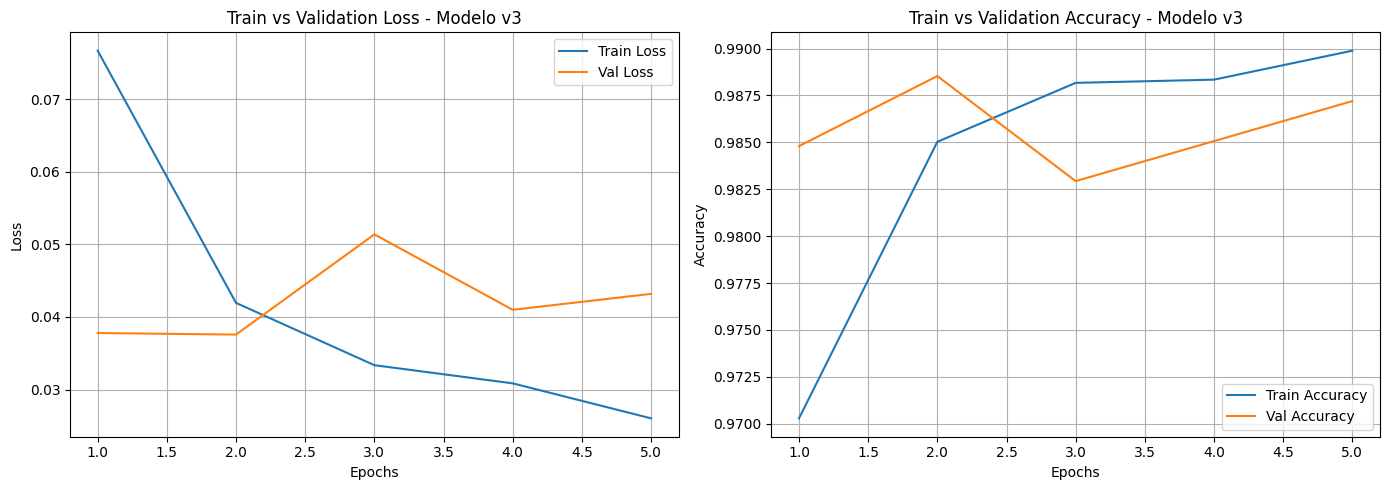

In [8]:
# Celda 10: Gráficas de entrenamiento (loss y accuracy)

epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(14, 5))

# ----------------------------
# Gráfica 1: Train vs Val Loss
# ----------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss - Modelo v3")
plt.legend()
plt.grid(True)

# ----------------------------
# Gráfica 2: Train vs Val Accuracy
# ----------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Accuracy")
plt.plot(epochs_range, history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy - Modelo v3")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Celda 8 – Evaluación detallada en el set de validación

In [9]:
# Celda 8: Evaluación final en el conjunto de validación

criterion = nn.CrossEntropyLoss()
val_loss, val_acc, val_prec, val_rec, val_f1, val_labels, val_preds = eval_one_epoch(
    model, criterion, val_loader, device
)

print(f"Validación - Loss: {val_loss:.4f}")
print(f"Accuracy:  {val_acc:.4f}")
print(f"Precisión: {val_prec:.4f}")
print(f"Sensibilidad (Recall): {val_rec:.4f}")
print(f"F1-score:  {val_f1:.4f}\n")

print("Classification Report (validación):")
print(classification_report(val_labels, val_preds, target_names=["cat", "dog"]))


Validación - Loss: 0.0432
Accuracy:  0.9872
Precisión: 0.9828
Sensibilidad (Recall): 0.9913
F1-score:  0.9871

Classification Report (validación):
              precision    recall  f1-score   support

         cat       0.99      0.98      0.99      1904
         dog       0.98      0.99      0.99      1846

    accuracy                           0.99      3750
   macro avg       0.99      0.99      0.99      3750
weighted avg       0.99      0.99      0.99      3750



Celda 9 – Matriz de confusión con 100 imágenes “nuevas” 

Matriz de confusión (holdout de 100 imágenes):
[[43  0]
 [ 0 57]]


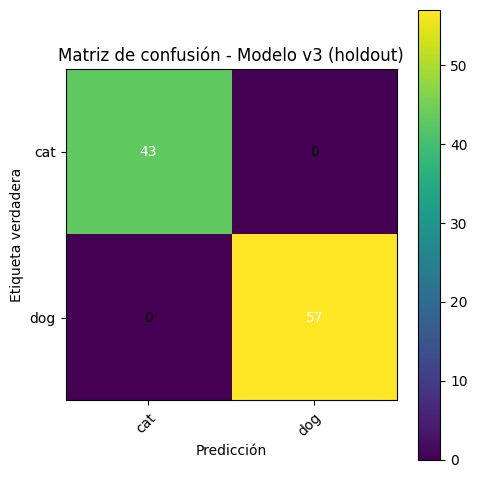

In [10]:
# Celda 9: Matriz de confusión con 100 imágenes del holdout

# Seleccionar hasta 100 imágenes de holdout (si hay menos, usamos todas)
num_holdout_samples = min(100, len(holdout_paths))
selected_paths = random.sample(holdout_paths, num_holdout_samples)

holdout_subset = CatsDogsDataset(selected_paths, transform=val_test_transform)
holdout_loader_100 = DataLoader(holdout_subset, batch_size=batch_size, shuffle=False, num_workers=0)

# Obtener predicciones
model.eval()
all_labels_h = []
all_preds_h = []

with torch.no_grad():
    for images, labels in holdout_loader_100:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_labels_h.extend(labels.cpu().numpy())
        all_preds_h.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels_h, all_preds_h)
print("Matriz de confusión (holdout de 100 imágenes):")
print(cm)

# Graficar matriz de confusión
classes = ["cat", "dog"]

fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    ylabel='Etiqueta verdadera',
    xlabel='Predicción'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Anotar los valores dentro de cada celda
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.title("Matriz de confusión - Modelo v3 (holdout)")
plt.tight_layout()
plt.show()


In [ ]:
# Celda 11: Guardar el modelo entrenado (versión 3)

model_filename = 'clasificador_perros_gatos_v3.pth'
torch.save(model.state_dict(), model_filename)
print(f"¡Modelo guardado como: {model_filename}!")


¡Modelo guardado como: clasificador_perros_gatos_v3.pth!
